Asi každý z nás občas narazí na následující problém:

Vyvíjím nějaký geniální software, jak také jinak. Testuji ho na testovacích datech, a všechno vypadá nádherně. Nicméně po nasazení do provozu to najednou začne drhnout, uživatelé si stěžují že je to pomalé a podobně.

Problém může být zakopaný v tom, že testovacích dat je obvykle výrazně méně než těch produkčních. No a ten můj software je sice geniální, ale má příliš velkou složitost, takže pro velká data je to pomalé.

Složitost se obvykle v dokumentaci značí _velkým O_, např. __O(n log n)__.

Pro základní algoritmy můžeme být někdy schopni odhadnout, jaká složitost našeho řešení asi je. Ale co pro složitější algoritmy? Tam asi pomůže jenom měření testovacích dat, analýza výsledků a predikce časové náročnosti po nasazení do reálného provozu.

A o to jsem se v tomhle povídání pokusil.

Všechny zdrojové kódy jsou k dispozici na GitHub: [py-algo-complex](https://github.com/jraska1/py-algo-complex)


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## Analyzovaná data
Pro analýzu potřebuji posbírat nějaká empiricky zjištěná data o mém algoritmu. 

Dělám to tak, že si postupně volím velikost testovacích dat, na které pošlu svůj algoritmus. Může to být počet řádků v databázi, nebo velikost souboru vstupních dat, nebo něco podobného. No a následně měřím, jak dlouho mně algoritmus běžel. 

Takže výsledek jsou dvojice čísel: `( <velikost vzorku>, <doba běhu algoritmu> )`
Velikost vzorku je obvykle celé číslo větší jak nula. Době běhu algoritmu pak reálné číslo, obvykle v sekundách nebo v milisekundách.

Takhle nějak by mohla vypadat analyzovaná data (doba běhu jsou milisekundy):

`10 384.8
30 486.4
50 876.6
70 1142.2
90 1861.0
100 2239.5
300 21175.3
500 58231.4
700 115257.1
900 191215.3
`

## Co budu na datech zjišťovat
Postupně budu zjišťovat:
* odhad složitosti algoritmu, tedy vybrat složitost __O__, která nejblíže odpovídá naměřeným datům
* parametery funkce, kterou proložím naměřená data (regresní analýza)
* vyhodnocení funkce pro zadanou velikost produkčních dat

## Komplexnost algoritmu
Pro další bádání jsem si vybral následující sadu komplexity algoritmu a k nim příslušných funkcí:

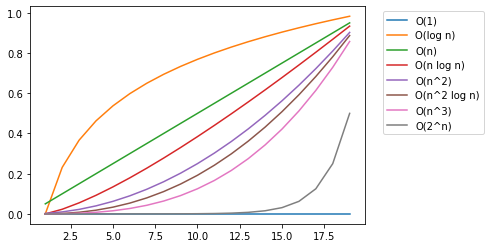

In [2]:
X = 20

compl = {
    'O(1)':         lambda x: np.zeros(x.shape) if isinstance(x, np.ndarray) else 1,
    'O(log n)':     lambda x: np.log2(x),
    'O(n)':         lambda x: x,
    'O(n log n)':   lambda x: x * np.log2(x),
    'O(n^2)':       lambda x: np.power(x, 2),
    'O(n^2 log n)': lambda x: np.power(x, 2) * np.log2(x),
    'O(n^3)':       lambda x: np.power(x, 3),
    'O(2^n)':       lambda x: np.exp2(x),
}
x = np.array(range(1, X))

for name, f in compl.items():
    y = f(x) / f(X)
    plt.plot(x, y, label=name)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

V tomto případě se pokouším zjistit, který průběh výše uvedené funkce nejvíce odpovídá mým naměřeným datům. Nejde mně tedy ani o velikosti jednotlivých čísel, jako spíše o tvar křivky.

Je zde ovšem jedem problém. V případě velkých komplexností, jako je např. O(2^n), se můžu pro relativně malé číslo __n__ dostat mimo rozsah reálných čísel. 

Proto nejříve provedu _normalizaci_ naměřených dat. Zvolím si nějaké rozumné číslo pro velikost __n__, něco mezi 20 a 100. Dále pak analyzovaná data převedu do rozsahu 0..n pro velikost vzorku, a 0..1 pro dobu běhu algoritmu. 

Na takto normalizovaná data již můžu použít metodu nejmenších čtverců pro porovnání s funkcemi komplexity.

In [3]:
def complexity_phase(x_values, y_values, samples):
    """
    Chooses algorithm complexity, which best suites provided data sample.

    :param x_values: independent variable representing sample data count
    :param y_values: dependent variable representing execution time (usually in seconds)
    :param samples:  number of samples used for normalization
    :return:         algorithm complexity label
    """
    x = np.array(x_values)
    y = np.array(y_values)

    xx = np.linspace(np.min(x), np.max(x), samples, dtype=int)
    yy = np.interp(xx, x, y)

    min_y = np.min(yy)
    max_y = np.max(yy)
    norm_x = np.arange(1, samples + 1)
    norm_y = (yy - min(y)) / (max_y - min_y)

    complexity = {
        'O(1)':         (lambda v: np.ones(v.shape),                2.0),
        'O(log n)':     (lambda v: np.log2(v),                      np.log2(samples)),
        'O(n)':         (lambda v: v,                               samples),
        'O(n log n)':   (lambda v: v * np.log2(v),                  samples * np.log2(samples)),
        'O(n^2)':       (lambda v: np.power(v, 2),                  np.power(samples, 2)),
        'O(n^2 log n)': (lambda v: np.power(v, 2) * np.log2(v),     np.power(samples, 2) * np.log2(samples)),
        'O(n^3)':       (lambda v: np.power(v, 3),                  np.power(samples, 3)),
        'O(2^n)':       (lambda v: np.exp2(v),                      np.exp2(samples)),
    }

    res = []
    for comp, (func, coef) in complexity.items():
        z = np.sum(np.power(norm_y - func(norm_x) / coef, 2))
        res.append((comp, z))
    return min(res, key=lambda a: a[1])[0]

data_path = './AlgorithmComplexity'
data_sets = [
    'data01.txt',
    'data02.txt',
    'data03.txt',
    'data04.txt',
    'data05.txt',
    'data06.txt',
    'data07.txt',
]

for sample in data_sets:
    values_x, values_y = [], []
    with open(os.path.join(data_path, sample), 'r') as f:
        complexity = f.readline().strip()
        for l in f:
            x, y = l.split()
            values_x.append(int(x))
            values_y.append(float(y))

    x = np.array(values_x)
    y = np.array(values_y)
    
    estimated_complexity = complexity_phase(x, y, 100)
    
    print(f"{sample}: {estimated_complexity}")

data01.txt: O(1)
data02.txt: O(n)
data03.txt: O(n log n)
data04.txt: O(n^2)
data05.txt: O(n^2)
data06.txt: O(n^3)
data07.txt: O(2^n)


## Parametry regresní funkce
Teď, když už mám vybranout funkci komplexnosti, se pokusím spočítat její parametry. Tady mně již jde o skutečné hodnoty, proto žádná normalizace nepřipadá v úvahu. 

Do každé funkce jsem doplnil ještě komplesnost O(1), protože spuštění každého algoritmu může mít nějakou režii bez ohledu na velikost vzorku dat.

Dále provedu regresní analázů pro zadanou funkci a testovací data. Výsledkem jsou pak parametry funkce:

In [4]:
REGRESSION_FUNCTIONS = {
    'O(1)':             (lambda x, a: a,                                        "{0:6f}"),
    'O(log n)':         (lambda x, a, b: a + b * np.log2(x),                    "{0:6f} + {1:6f} * log2(x)"),
    'O(n)':             (lambda x, a, b: a + b * x,                             "{0:6f} + {1:6f} * x"),
    'O(n log n)':       (lambda x, a, b: a + b * x * np.log2(x),                "{0:6f} + {1:6f} * x * log2(x)"),
    'O(n^2)':           (lambda x, a, b: a + b * np.power(x, 2, dtype=float),   "{0:6f} + {1:6f} * x^2"),
    'O(n^2 log n)':     (lambda x, a, b: a + b * np.power(x, 2, dtype=float) * np.log2(x),   "{0:6f} + {1:6f} * x^2 * log2(x)"),
    'O(n^3)':           (lambda x, a, b: a + b * np.power(x, 3, dtype=float),   "{0:6f} + {1:6f} * x^3"),
    'O(2^n)':           (lambda x, a, b: a + b * np.power(2, x, dtype=float),   "{0:6f} + {1:6f} * 2^x"),
}

def regression_phase(x_values, y_values, label):
    """
    Computes regression function parameters.

    :param x_values: independent variable representing sample data count
    :param y_values: dependent variable representing execution time (usually in seconds)
    :param label:    complexity label
    :return:         regression function parameters
    """
    x = np.array(x_values, dtype=float)
    y = np.array(y_values, dtype=float)

    popt, pcov = curve_fit(REGRESSION_FUNCTIONS[label][0], x, y)
    return popt

for sample in data_sets:
    values_x, values_y = [], []
    with open(os.path.join(data_path, sample), 'r') as f:
        complexity = f.readline().strip()
        for l in f:
            x, y = l.split()
            values_x.append(int(x))
            values_y.append(float(y))

    x = np.array(values_x)
    y = np.array(values_y)
    
    params = regression_phase(x, y, complexity)
    
    print(f"{sample}: {REGRESSION_FUNCTIONS[complexity][1].format(*params)}")

data01.txt: 186000.000000
data02.txt: 300.012861 + 26.093507 * x
data03.txt: -4389.523109 + 6.811732 * x * log2(x)
data04.txt: 1028.894797 + 0.026123 * x^2
data05.txt: -41088.241734 + 5.702016 * x^2 * log2(x)
data06.txt: 1458.612242 + 0.026220 * x^3
data07.txt: 3137.905018 + 0.199635 * 2^x


## Odhad doby pro produkční data
A když už mám zjištěnou regresní funkci a její parametry, můžu velice jednoduše odhadnout, jak dluho by mně mohlo trvat spuštění algoritmu pro velikost produkčních dat.

Tak například pro testovacá data _data07.txt_:

In [5]:
x = 100
a, b = 3137.905018, 0.199635
f = REGRESSION_FUNCTIONS['O(2^n)'][0]
y = f(x, a, b)

print(f"{x=} {y=}")

x=100 y=2.530674275765626e+29



A to je vše. Třeba vám to k něčemu bude.
